# 403 Iterate for CDR
In this notebook we will assess the new CDR needs based on an iterative search.

In [217]:
#ENSEMBLE_MEMBER = 4
ENSEMBLE_MEMBER = 528
#MODEL='REMIND-MAgPIE 2.1-4.3'
MODEL='COFFEE 1.1'
#SCENARIO='DeepElec_SSP2_ HighRE_Budg900'
SCENARIO='EN_NPi2020_400'

In [218]:
import json
import os
import platform
from pathlib import Path

import time

import copy
import dotenv
import matplotlib.pyplot as plt
import openscm_runner
import scmdata
import pyam
import pandas as pd
import numpy as np
from scipy.optimize import minimize_scalar

import sys
sys.path.append('../scripts/')
from cdr import *

from climate_assessment.climate.wg3 import clean_wg3_scenarios
from climate_assessment.climate.magicc7 import get_magicc7_configurations

from utils import rebase_temperatures_wg3

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [219]:
dotenv.load_dotenv()

True

In [220]:
os_type = platform.system()
print(os_type)

match os_type:
    case 'Darwin':
        os.environ['MAGICC_EXECUTABLE_7']=os.path.join(
            os.environ['MAGICC_7_BIN'],
            'magicc-darwin-amd64'
        )
        os.environ['DYLD_LIBRARY_PATH'] = os.environ['DYLD_PATH_GCC']
    case 'Linux':
        os.environ['MAGICC_EXECUTABLE_7']=os.path.join(
            os.environ['MAGICC_7_BIN'],
            'magicc'
        )

Linux


Step 1: Load the MAGICC configurations and select the ensemble member (climate realisation) that we want to run through for this study.

In [221]:
magicc_cfgs, _ = get_magicc7_configurations(
    magicc_version="v7.5.3",
    magicc_probabilistic_file=os.environ['MAGICC_AR6_PROBABILISTIC_DISTRIBUTION'],
    magicc_extra_config=None,
    num_cfgs=600,
    co2_and_non_co2_warming=False
)

In [222]:
config_for_run = [magicc_cfgs[ENSEMBLE_MEMBER]]

Step 2: Load the necessary emissions-related files for this assessment. We need:
* The adapted novel CDR estimates lookup table
* The emission dataset to input to the climate model
* The original novel CDR estimates that we will use for the calibration iterations and the optimisation

In [223]:
novel_cdr = pyam.IamDataFrame(
    Path(
        '../data/402_first_guess.csv'
    )
)

pyam.core - INFO: Reading file ../data/402_first_guess.csv


In [224]:
emissions = pyam.IamDataFrame(
    Path(
        '../data/100_scenarios.csv'
    )
)

pyam.core - INFO: Reading file ../data/100_scenarios.csv


In [225]:
metrics = pd.read_csv(
    Path(
        '../data/401_lookup.csv'
    ),
    index_col=[0,1, 2]
)

In [226]:
novel_cdr_original = pyam.IamDataFrame(
    Path(
        '../data/100_novel_cdr.csv'
    )
)

pyam.core - INFO: Reading file ../data/100_novel_cdr.csv


Step 3: Filter both the datasets for the necessary model and scenario. Additionally, for the novel CDR dataframe, downselect it to get the ensemble member of choice.

In [227]:
novel_cdr_for_iteration = (
    novel_cdr
    .filter(
        ensemble_member=ENSEMBLE_MEMBER,
        model=MODEL,
        scenario=SCENARIO
    )
)

In [228]:
novel_cdr_for_iteration.interpolate(
    time=range(2015, 2101),
    inplace=True
)

In [229]:
emissions_for_iteration = (
    emissions
    .filter(
        model=MODEL,
        scenario=SCENARIO
    )
)

In [230]:
emissions_for_iteration.swap_time_for_year(inplace=True)

In [231]:
novel_cdr_original_filtered = (
    novel_cdr_original
    .filter(
        model=MODEL,
        scenario=SCENARIO
    )
    .interpolate(
        time=range(2015, 2101)
    )
)

Step 4: We need the year of net zero CO2 and zero out the CDR before (so that we do not have a double counting effect)

In [232]:
def process_novel_cdr(data, netzero_timing):
    data_to_return = (
        data.timeseries()
        -
        novel_cdr_original_filtered.timeseries()
    )
    return pyam.IamDataFrame(data_to_return)

In [233]:
netzero_timing = metrics.loc[
    (MODEL, SCENARIO, ENSEMBLE_MEMBER),
    'netzero|CO2'
]

In [234]:
novel_cdr_to_crunch = process_novel_cdr(
    novel_cdr_for_iteration,
    netzero_timing
)

In [235]:
novel_cdr_for_iteration.set_meta(
    name='netzero|CO2',
    meta=netzero_timing
)

Step 4: Make a function that constructs a new emission dataframe to run through the simple climate model.

In [236]:
def construct_new_emissions_dataframe(
        emissions, cdr
):
    emissions_to_return = copy.deepcopy(emissions)
    # Step 1: Get the CDR dataframe
    cdr_altered = pyam.IamDataFrame(
        cdr
        .timeseries()
        .reset_index()
        .drop(columns=cdr.extra_cols)
    )
    # Step 2: Pull out the emissions
    co2_ffi_var = 'AR6 climate diagnostics|Infilled|Emissions|CO2|Energy and Industrial Processes'
    co2_ffi = (
        emissions_to_return
        .filter(variable=co2_ffi_var)
    )
    # Step 3: Create a non CO2 dataframe
    nonco2_ffi = (
        emissions_to_return
        .filter(
            variable=co2_ffi_var,
            keep=False
        )
    )
    # Step 4: Aggregate the two variables
    concat = pyam.concat([cdr_altered, co2_ffi])
    concat_co2_ffi = concat.subtract(
        a=co2_ffi_var,
        b='Carbon Dioxide Removal|Novel',
        name=co2_ffi_var,
        ignore_units='Mt CO2/yr'
    )
    # Step 5: Return this
    df_to_return = pyam.concat([concat_co2_ffi, nonco2_ffi])
    return df_to_return.filter(year=range(2015, 2101))

In [237]:
test = construct_new_emissions_dataframe(emissions_for_iteration, novel_cdr_to_crunch)

In [238]:
novel_cdr_for_iteration.timeseries()

,,,,,,,2010,2015,2016,2017,2018,2019,2020,2021,2022,2023,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
model,scenario,region,variable,unit,angle,ensemble_member,,,,,,,,,,,,,,,,,,,,,
COFFEE 1.1,EN_NPi2020_400,World,Carbon Dioxide Removal|Novel,Mt CO2/yr,34.376941,528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12923.873876,13128.771986,13333.670096,13538.568207,13743.466317,13948.364427,14153.262538,14358.160648,14563.058758,14767.956868


/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pyam/plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pyam/plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():


Text(0.5, 1.0, '')

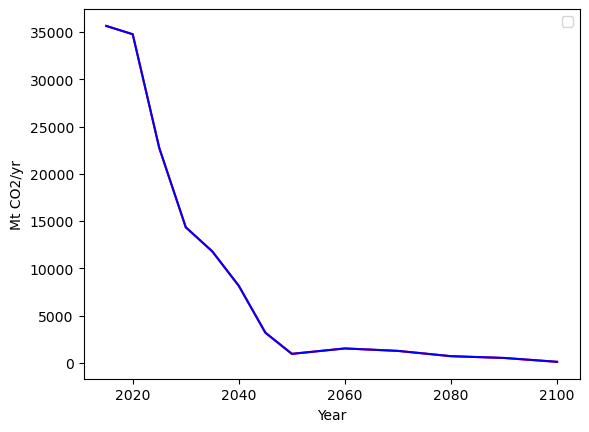

In [239]:
fig, ax = plt.subplots()

test.filter(
    variable='*Emissions|CO2|Energy and Industrial Processes'
).plot(ax=ax, color='red')

emissions_for_iteration.filter(
    variable='*Emissions|CO2|Energy and Industrial Processes'
).plot(ax=ax, color='blue')

ax.set_title('')

Step 6: Create the input for MAGICC and run this through for a first cut.

In [240]:
input_scm = scmdata.ScmRun(
    clean_wg3_scenarios(test)
)

/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


In [241]:
try:
    temp_confirmation =  openscm_runner.run(
        {'MAGICC7':config_for_run},
        input_scm,
        output_variables=[
            'Surface Temperature'
        ]
    )
    temp_proc = (
        rebase_temperatures_wg3(
            temp_confirmation
        )
        .timeseries()
    )
    temp_calibrate_2100 = temp_proc['2100-01-01'].values[0].round(2)
except:
    temp_calibrate_2100 = 1.5

Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-s852uo_v
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-s852uo_v
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-s852uo_v/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-s852uo_v
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results


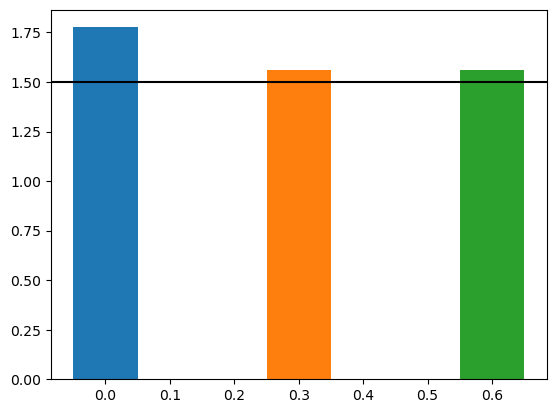

In [242]:
fig, ax = plt.subplots()

metrics_small = metrics.loc[
    (MODEL, SCENARIO, ENSEMBLE_MEMBER),
]

ax.bar(x=0, height=metrics_small['peak_warming'], width=0.1)
ax.bar(x=0.3, height=metrics_small['2100_warming'], width=0.1)
ax.bar(x=0.6, height=temp_calibrate_2100, width=0.1)
ax.axhline(1.5, color='black')

Step 7: Now that we know the direction (whether above or below), we now need a few calibration runs to get to the correct direction.

In [243]:
deviation = temp_calibrate_2100 - 1.5
print(deviation)

0.06000000000000005


In [244]:
def return_temperature_deviation(input_emissions):
    # Step 1: Run this through the simple climate model
    temperatures = openscm_runner.run(
        {'MAGICC7':config_for_run},
        input_emissions,
        output_variables=[
            'Surface Temperature'
        ]    
    )
    # Step 2: Rebase to 1850-1900 and return the 2100 value deviation
    temperatures_rebased = (
        rebase_temperatures_wg3(temperatures)
    )
    temp_2100 = (
        temperatures_rebased
        .timeseries()['2100-01-01']
        .values[0]
    )
    # Step 3: Return the deviation
    return temp_2100 - 1.5

In [245]:
novel_cdr_for_iteration.angle[0]
if deviation < 0:
    calibrate_type = 'reduce'
elif deviation > 0:
    calibrate_type = 'increase'
else:
    calibrate_type = 'none'

In [246]:
novel_cdr_for_iteration

<class 'pyam.core.IamDataFrame'>
Index:
 * model           : COFFEE 1.1 (1)
 * scenario        : EN_NPi2020_400 (1)
Timeseries data coordinates:
   region          : World (1)
   variable        : Carbon Dioxide Removal|Novel (1)
   unit            : Mt CO2/yr (1)
   angle           : 34.37694101250946 (1)
   ensemble_member : 528 (1)
   year            : 2010, 2015, 2016, 2017, 2018, 2019, 2020, ... 2100 (87)
Meta indicators:
   exclude (bool) False (1)
   netzero|CO2 (int64) 2075 (1)

In [247]:
novel_cdr_original_filtered.meta = novel_cdr_for_iteration.meta

In [248]:
def initial_calibration(
        emissions,
        cdr_first_guess,
        angle_first_guess,
        current_deviation
):
    # Step 1: Create a dictionary to store the calibrations
    calibration = {}
    emissions_copy = copy.deepcopy(emissions)
    cdr = copy.deepcopy(cdr_first_guess)
    # Step 2: Determine walk direction
    if current_deviation > 0:
        new_deviation = current_deviation
        step_size=0.5
        while new_deviation > 0:
            new_angle = angle_first_guess + step_size
            print(new_deviation, new_angle)
            if new_angle > 91:
                break
            new_cdr, _ = rotate_and_calc_cumulative(
                cdr,
                new_angle
            )
            new_emissions = (
                scmdata.ScmRun(
                    clean_wg3_scenarios(
                        construct_new_emissions_dataframe(
                            emissions_copy,
                            process_novel_cdr(new_cdr, cdr.meta['netzero|CO2'].values[0])
                        )
                    
                    )
                )
            )
            new_deviation = return_temperature_deviation(new_emissions)
            calibration[new_angle] = new_deviation
            step_size += step_size
    elif current_deviation < 0:
        step_size=5
        new_deviation = current_deviation
        while new_deviation < 0:
            new_angle = angle_first_guess - step_size
            if new_angle < 0:
                break
            print(new_deviation, new_angle)
            new_cdr, _ = rotate_and_calc_cumulative(
                cdr,
                new_angle
            )
            new_emissions = (
                scmdata.ScmRun(
                    clean_wg3_scenarios(
                        construct_new_emissions_dataframe(
                            emissions_copy,
                            process_novel_cdr(new_cdr, cdr.meta['netzero|CO2'].values[0])
                        )
                    
                    )
                )
            )
            new_deviation = return_temperature_deviation(new_emissions)
            calibration[new_angle] = new_deviation
            step_size += step_size
    return pd.DataFrame(
        calibration.items(),
        columns=['angle', 'deviation']
    )

In [249]:
initial_calibration_set = initial_calibration(
    emissions_for_iteration,
    novel_cdr_original_filtered,
    novel_cdr_for_iteration.angle[0],
    current_deviation=deviation,
)

0.06000000000000005 34.87694101250946


/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-8vuky6m9
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-8vuky6m9
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-8vuky6m9/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-8vuky6m9
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


0.061594225038882566 35.37694101250946


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-erv3_ucp
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-erv3_ucp
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-erv3_ucp/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-erv3_ucp
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results


0.061591857582063536 36.37694101250946


/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-qm4w_4p3
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-qm4w_4p3
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-qm4w_4p3/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-qm4w_4p3
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


0.061587027714256504 38.37694101250946


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-loowa17q
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-loowa17q
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-loowa17q/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-loowa17q
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results


0.06157700741125316 42.37694101250946


/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-pqfysp8a
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-pqfysp8a
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-pqfysp8a/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-pqfysp8a
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results


0.061555156241288156 50.37694101250946


/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-67icz6pg
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-67icz6pg
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-67icz6pg/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-67icz6pg
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


0.06150157559023306 66.37694101250946


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-0hhcki88
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-0hhcki88
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-0hhcki88/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-0hhcki88
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results


0.06130593187421196 98.37694101250946


In [250]:
initial_calibration_set

,angle,deviation
0,34.876941,0.061594
1,35.376941,0.061592
2,36.376941,0.061587
3,38.376941,0.061577
4,42.376941,0.061555
5,50.376941,0.061502
6,66.376941,0.061306


In [251]:
def objective(angle, emissions, cdr_first_guess):
    # Step 1: Get the new CDR pathway
    new_cdr, _ = rotate_and_calc_cumulative(
        cdr_first_guess,
        angle
    )
    # Step 2: Get the new emissions pathway
    new_emissions = (
        scmdata.ScmRun(
            clean_wg3_scenarios(
                construct_new_emissions_dataframe(
                    emissions,
                    process_novel_cdr(new_cdr, cdr_first_guess.meta['netzero|CO2'].values[0])
                )        
            )
        )
    )
    new_deviation = abs(return_temperature_deviation(new_emissions))
    time.sleep(0.5)
    return new_deviation

In [252]:
novel_cdr_for_iteration.angle[0]

34.37694101250946

In [253]:
if calibrate_type == 'increase':
    try: max_angle = min(90, initial_calibration_set.iloc[-1]['angle'])
    except: max_angle=90
    bounds = (novel_cdr_for_iteration.angle[0], max_angle)
elif calibrate_type == 'reduce':
    try: min_angle = max(0, initial_calibration_set.iloc[-1]['angle'])
    except: min_angle=0
    bounds = (min_angle, novel_cdr_for_iteration.angle[0])
elif calibrate_type == 'none':
    bounds = (novel_cdr_for_iteration.angle[0], novel_cdr_for_iteration.angle[0]) # Catch the issue where deviation is 0

In [254]:
bounds

(34.37694101250946, 66.37694101250946)

try:
    max_angle = min(90, initial_calibration_set.iloc[-1]['angle'])
except: max_angle=90

In [255]:
try:
    result = minimize_scalar(
        objective,
        bounds=bounds,
        args=(emissions_for_iteration, novel_cdr_original_filtered),
        method='bounded'
    )
except:
    result = minimize_scalar(
        objective,
        bounds=(0,90),
        args=(emissions_for_iteration, novel_cdr_original_filtered),
        method='bounded'
    )

/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-xk3pwm4y
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-xk3pwm4y
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-xk3pwm4y/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-xk3pwm4y
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-jd8mc5x1
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-jd8mc5x1
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-jd8mc5x1/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-jd8mc5x1
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-ogoxzwvu
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-ogoxzwvu
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-ogoxzwvu/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-ogoxzwvu
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-e80q9g1h
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-e80q9g1h
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-e80q9g1h/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-e80q9g1h
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-8uvwjk7x
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-8uvwjk7x
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-8uvwjk7x/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-8uvwjk7x
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-plin1j8f
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-plin1j8f
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-plin1j8f/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-plin1j8f
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-nam7xvhq
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-nam7xvhq
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-nam7xvhq/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-nam7xvhq
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-buuj4f8j
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-buuj4f8j
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-buuj4f8j/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-buuj4f8j
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-0a7hgalm
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-0a7hgalm
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-0a7hgalm/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-0a7hgalm
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-pef_xe5f
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-pef_xe5f
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-pef_xe5f/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-pef_xe5f
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-1rhaolu9
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-1rhaolu9
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-1rhaolu9/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-1rhaolu9
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-1bt57t86
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-1bt57t86
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-1bt57t86/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-1bt57t86
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-5brbbktm
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-5brbbktm
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-5brbbktm/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-5brbbktm
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-qbgbdtgg
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-qbgbdtgg
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-qbgbdtgg/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-qbgbdtgg
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-ujrj94_5
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-ujrj94_5
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-ujrj94_5/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-ujrj94_5
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-u1_u4c5i
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-u1_u4c5i
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-u1_u4c5i/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-u1_u4c5i
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-r0uhmyeo
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-r0uhmyeo
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-r0uhmyeo/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-r0uhmyeo
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-y4dv_qyk
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-y4dv_qyk
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-y4dv_qyk/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-y4dv_qyk
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-u20gr7vz
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-u20gr7vz
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-u20gr7vz/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-u20gr7vz
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-8rgdm400
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-8rgdm400
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-8rgdm400/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-8rgdm400
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-difv9cfp
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-difv9cfp
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-difv9cfp/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-difv9cfp
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-8wvna9ty
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-8wvna9ty
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-8wvna9ty/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-8wvna9ty
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-_76g60u3
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-_76g60u3
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-_76g60u3/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-_76g60u3
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-lmncew8_
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-lmncew8_
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-lmncew8_/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-lmncew8_
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-87l58vwk
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-87l58vwk
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-87l58vwk/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-87l58vwk
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-_t38duo0
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-_t38duo0
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-_t38duo0/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-_t38duo0
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-upyf7gip
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-upyf7gip
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-upyf7gip/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-upyf7gip
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-1ajfmzyx
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-1ajfmzyx
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-1ajfmzyx/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-1ajfmzyx
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-53s_1bya
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-53s_1bya
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-53s_1bya/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-53s_1bya
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-2km3azxk
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-2km3azxk
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-2km3azxk/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-2km3azxk
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-h0huxbtn
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-h0huxbtn
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-h0huxbtn/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-h0huxbtn
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-xfpwvulh
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-xfpwvulh
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-xfpwvulh/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-xfpwvulh
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results


In [256]:
if result.fun > 0.05 and calibrate_type == "increase":
   result = minimize_scalar(
        objective,
        bounds=(0,90),
        args=(emissions_for_iteration, novel_cdr_original_filtered),
        method='bounded'
    ) 

/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-u4o80rm_
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-u4o80rm_
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-u4o80rm_/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-u4o80rm_
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-uxxnd1_f
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-uxxnd1_f
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-uxxnd1_f/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-uxxnd1_f
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-9zkiemwg
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-9zkiemwg
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-9zkiemwg/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-9zkiemwg
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-d8fv8qqe
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-d8fv8qqe
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-d8fv8qqe/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-d8fv8qqe
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-is5c0om2
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-is5c0om2
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-is5c0om2/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-is5c0om2
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-dixpz_sw
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-dixpz_sw
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-dixpz_sw/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-dixpz_sw
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-7akid1r5
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-7akid1r5
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-7akid1r5/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-7akid1r5
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-fkampqp2
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-fkampqp2
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-fkampqp2/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-fkampqp2
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-rzlendu_
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-rzlendu_
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-rzlendu_/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-rzlendu_
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-4xyhs4vy
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-4xyhs4vy
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-4xyhs4vy/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-4xyhs4vy
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-z0i6dg_3
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-z0i6dg_3
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-z0i6dg_3/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-z0i6dg_3
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-oycb5i6r
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-oycb5i6r
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-oycb5i6r/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-oycb5i6r
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-uuisralv
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-uuisralv
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-uuisralv/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-uuisralv
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-kwcc4kj0
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-kwcc4kj0
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-kwcc4kj0/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-kwcc4kj0
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-nztllwdg
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-nztllwdg
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-nztllwdg/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-nztllwdg
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-ttbu8elr
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-ttbu8elr
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-ttbu8elr/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-ttbu8elr
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-ovoazr1b
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-ovoazr1b
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-ovoazr1b/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-ovoazr1b
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-7i79et3f
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-7i79et3f
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-7i79et3f/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-7i79et3f
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-am5gqoi1
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-am5gqoi1
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-am5gqoi1/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-am5gqoi1
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-3r94xbwd
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-3r94xbwd
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-3r94xbwd/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-3r94xbwd
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-azf12pcb
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-azf12pcb
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-azf12pcb/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-azf12pcb
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-rg3_rd5r
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-rg3_rd5r
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-rg3_rd5r/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-rg3_rd5r
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-4xs93hx_
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-4xs93hx_
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-4xs93hx_/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-4xs93hx_
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-8ki44ldz
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-8ki44ldz
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-8ki44ldz/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-8ki44ldz
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-lnjdufds
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-lnjdufds
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-lnjdufds/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-lnjdufds
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-gh873jrz
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-gh873jrz
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-gh873jrz/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-gh873jrz
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-0a2wlwly
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-0a2wlwly
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-0a2wlwly/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-0a2wlwly
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-7o_vai_6
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-7o_vai_6
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-7o_vai_6/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-7o_vai_6
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-7y873v3d
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-7y873v3d
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-7y873v3d/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-7y873v3d
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results


Last step: Make a function to construct and return the necessary CDR and temperature pathways.

In [257]:
def objective(angle, emissions, cdr_first_guess):
    # Step 1: Get the new CDR pathway
    new_cdr, _ = rotate_and_calc_cumulative(
        cdr_first_guess,
        angle
    )
    # Step 2: Get the new emissions pathway
    new_emissions = (
        scmdata.ScmRun(
            clean_wg3_scenarios(
                construct_new_emissions_dataframe(
                    emissions,
                    process_novel_cdr(new_cdr, cdr_first_guess.meta['netzero|CO2'].values[0])
                )        
            )
        )
    )
    new_deviation = abs(return_temperature_deviation(new_emissions))
    return new_deviation

In [258]:
def compile_necessary_output_files(result):
    # Step 1: Get the new CDR pathway
    new_cdr, cumulative_cdr = rotate_and_calc_cumulative(
        novel_cdr_original_filtered,
        result.x
    )
    new_cdr.set_meta(
        name='cumulative_cdr',
        meta=cumulative_cdr
    )
    # Step 2: Get the new emissions pathway
    new_emissions = (
        scmdata.ScmRun(
            clean_wg3_scenarios(
                construct_new_emissions_dataframe(
                    emissions_for_iteration,
                    process_novel_cdr(new_cdr, novel_cdr_original_filtered.meta['netzero|CO2'].values[0])
                )        
            )
        )
    )
    # Step 4: Calculate the warming
    new_warming = openscm_runner.run(
        {'MAGICC7':config_for_run},
        new_emissions,
        output_variables=[
            'Surface Temperature'
        ]    
    )
    # Step 4: Rebase and return
    new_warming_rebased = (
        rebase_temperatures_wg3(new_warming)
    )
    return new_cdr, new_warming_rebased

In [259]:
cdr_pathway, temperature_pathway = compile_necessary_output_files(result)

/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 16 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /tmp/gaurav/pymagicc-qo0odl7s
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /tmp/gaurav/pymagicc-qo0odl7s
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /tmp/gaurav/pymagicc-qo0odl7s/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /tmp/gaurav/pymagicc-qo0odl7s
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results


In [260]:
result

 message: Solution found.
 success: True
  status: 0
     fun: 5.509043328189023e-07
       x: 89.8292194839185
     nit: 29
    nfev: 29

/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pyam/plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pyam/plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/scmdata/plotting.py:79: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.lineplot(data=plt_df, **kwargs)


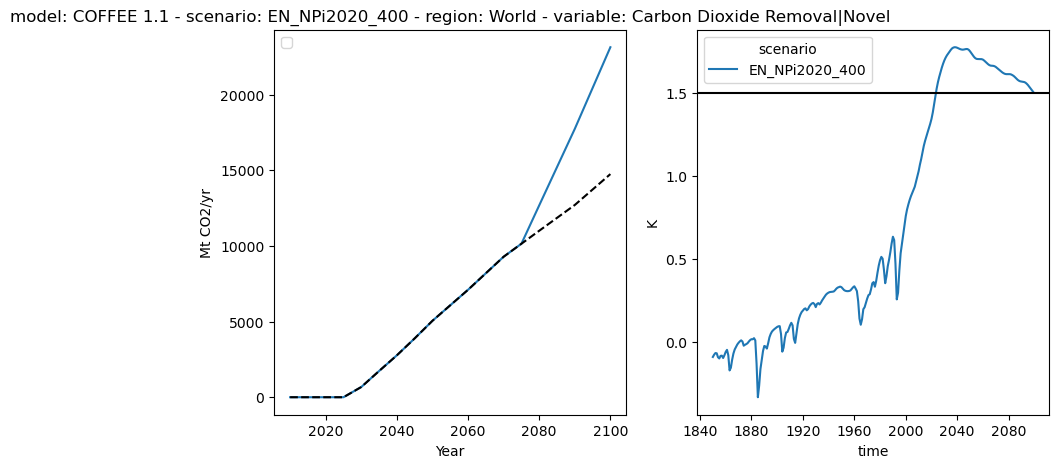

In [261]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# First, plot the CDR pathway
cdr_pathway.plot(ax=ax[0])
novel_cdr_original_filtered.plot(ax=ax[0], color='black', linestyle='--')

# Plot the temperature
temperature_pathway.filter(year=range(1850, 2100)).line_plot(ax=ax[1])
ax[1].axhline(1.5, color='black')

Save the files out for further assessment.

In [262]:
output_path=os.environ['OUTPUT_PATH']

In [263]:
if '/' in MODEL:
    MODEL=MODEL.replace('/', '-')

In [264]:
cdr_output = Path(
    f"{output_path}/results/CDR_{MODEL}_{SCENARIO}_{ENSEMBLE_MEMBER}.csv"
)
temp_output = Path(
    f"{output_path}/results/TEMP_{MODEL}_{SCENARIO}_{ENSEMBLE_MEMBER}.csv"
)

In [265]:
cdr_pathway.to_csv(
    cdr_output
)

In [266]:
temperature_pathway.to_csv(
    temp_output
)

In [267]:
cdr_output

PosixPath('/mnt/PROVIDE/gaurav/results/CDR_COFFEE 1.1_EN_NPi2020_400_528.csv')

In [268]:
temp_output

PosixPath('/mnt/PROVIDE/gaurav/results/TEMP_COFFEE 1.1_EN_NPi2020_400_528.csv')